In [2]:
pip install transformers evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00


In [3]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=21851211c46eb301e1e0c9fa4d4884fcac5c77a90938867a809ceba225818657
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

In [16]:
# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)

models = [
    "microsoft/DialoGPT-medium",
    "suhasjain/DailoGPT-small-harrypotter",
    "microsoft/DialoGPT-large",
    "microsoft/DialoGPT-small",
    "satvikag/chatbot"
]

prompts = [
    "How is the weather today?",
    "When was harrypotter born?",
    "Tell me a joke.",
    "How is your health.",
    "What is your favorite color?"
]

responses = [
    "Its a pleasant sunny weather today.",
    "He was born on 31 July 1980",
    "One joke, coming up! What is a sea monster’s favorite snack? Ships and dip.",
    "Recently it is not good.",
    "My favorite color is pink."
]

result_dic = {}



In [17]:

# Function to calculate BLEU score
def cal_bleu(references, candidates):
    smoothie = SmoothingFunction().method4
    return corpus_bleu(references, candidates, smoothing_function=smoothie)

# Function to calculate ROUGE scores
def cal_rouge(references, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(references, candidate)
    rouge1 = scores['rouge1'].fmeasure
    rouge2 = scores['rouge2'].fmeasure
    rougeL = scores['rougeL'].fmeasure
    return rouge1, rouge2, rougeL

# Iterate through models
for model_name in models:
    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    response_lengths = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_name)

    # Tokenize prompts
    input_ids = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)["input_ids"]

    # Generate responses
    with torch.no_grad():
        output = model.generate(input_ids=input_ids, max_length=100)

    generated_response = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output]

    # Evaluate responses
    for response, generated_response in zip(responses, generated_response):
        # Calculate BLEU score
        bleu_score = cal_bleu([[response]], [[generated_response]])
        bleu_scores.append(bleu_score)

        # Calculate ROUGE scores
        rouge1, rouge2, rougeL = cal_rouge(response, generated_response)
        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)

        # Calculate response length
        response_lengths.append(len(generated_response.split()))

    # Calculate average scores
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    avg_rouge1_score = sum(rouge1_scores) / len(rouge1_scores)
    avg_rouge2_score = sum(rouge2_scores) / len(rouge2_scores)
    avg_rougeL_score = sum(rougeL_scores) / len(rougeL_scores)
    avg_response_length = sum(response_lengths) / len(response_lengths)

    # Store results
    result_dic[model_name] = {
        "BLEU": avg_bleu_score,
        "ROUGE-1": avg_rouge1_score,
        "ROUGE-2": avg_rouge2_score,
        "ROUGE-L": avg_rougeL_score,
        "Response Length": avg_response_length
    }
for model_name, scores in result_dic.items():
    print(f"Model: {model_name}")
    print(f"BLEU Score: {scores['BLEU']:.4f}")
    print(f"ROUGE-1 Score: {scores['ROUGE-1']:.4f}")
    print(f"ROUGE-2 Score: {scores['ROUGE-2']:.4f}")
    print(f"ROUGE-L Score: {scores['ROUGE-L']:.4f}")
    print(f"Average Response Length: {scores['Response Length']:.3f}")
# Display and save results
results_df = pd.DataFrame(result_dic).T
results_df.to_csv('results.csv')



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` t

Model: microsoft/DialoGPT-medium
BLEU Score: 0.0000
ROUGE-1 Score: 0.2401
ROUGE-2 Score: 0.0289
ROUGE-L Score: 0.1921
Average Response Length: 10.800
Model: suhasjain/DailoGPT-small-harrypotter
BLEU Score: 0.0000
ROUGE-1 Score: 0.3021
ROUGE-2 Score: 0.0667
ROUGE-L Score: 0.2525
Average Response Length: 5.000
Model: microsoft/DialoGPT-large
BLEU Score: 0.0000
ROUGE-1 Score: 0.3184
ROUGE-2 Score: 0.0697
ROUGE-L Score: 0.2739
Average Response Length: 7.000
Model: microsoft/DialoGPT-small
BLEU Score: 0.0000
ROUGE-1 Score: 0.3120
ROUGE-2 Score: 0.0752
ROUGE-L Score: 0.2910
Average Response Length: 5.200
Model: satvikag/chatbot
BLEU Score: 0.0000
ROUGE-1 Score: 0.3827
ROUGE-2 Score: 0.0890
ROUGE-L Score: 0.3394
Average Response Length: 5.800


In [18]:
result = pd.DataFrame(result_dic).T
result

,BLEU,ROUGE-1,ROUGE-2,ROUGE-L,Response Length
microsoft/DialoGPT-medium,0.0,0.240085,0.028903,0.192096,10.8
suhasjain/DailoGPT-small-harrypotter,0.0,0.302134,0.066667,0.252510,5.0
microsoft/DialoGPT-large,0.0,0.318416,0.069697,0.273854,7.0
microsoft/DialoGPT-small,0.0,0.312004,0.075214,0.290952,5.2
satvikag/chatbot,0.0,0.382727,0.088951,0.339394,5.8


TOPSIS analysis completed successfully. Results saved to topsis_reult.csv


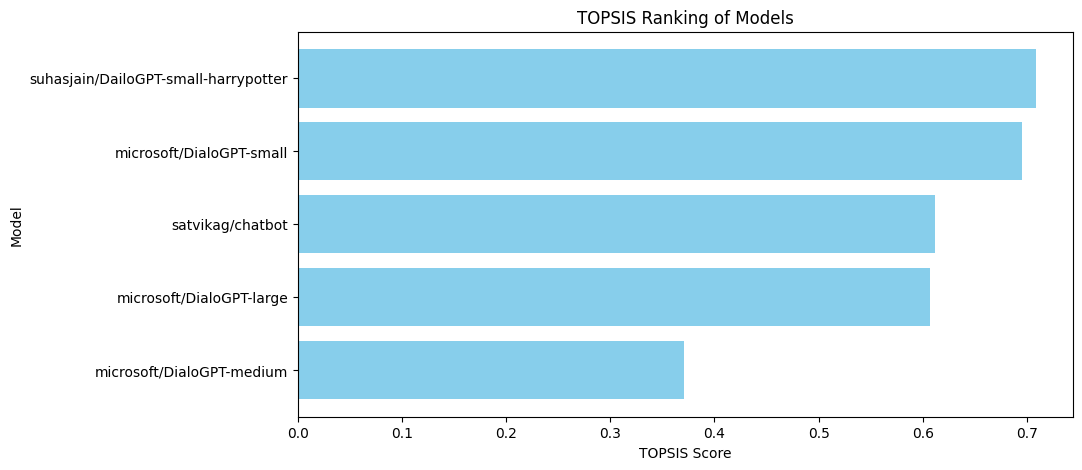

In [25]:
data=pd.read_csv("results.csv")
weights = '0.5,0.5,0.5,0.5,0.5'
impacts = '+,+,-,-,+'
if data.shape[1] < 3:
    raise ValueError("Input file does not contain three or more columns.")
if not data.iloc[:, 1:].apply(np.isreal).all().all():
    raise ValueError("Columns from 2nd to last do not contain numeric values only.")
if len(weights.split(',')) != len(impacts.split(',')) != data.shape[1] - 1:
    raise ValueError("Number of weights, impacts, and columns must be the same.")
if not all(impact in ['+', '-'] for impact in impacts.split(',')):
    raise ValueError("Impacts must be either +ve or -ve.")

norm_data = data.copy()
for i in range(1, data.shape[1]):
    norm_data.iloc[:, i] = data.iloc[:, i] / np.sqrt(np.sum(data.iloc[:, i]**2))

weight = np.array([float(weight) for weight in weights.split(',')])
wei_norm_data = norm_data.copy()
for i in range(1, norm_data.shape[1]):
    wei_norm_data.iloc[:, i] = norm_data.iloc[:, i] * weight[i-1]

ideal_value = []
worst_ideal_value = []

for i in range(1, wei_norm_data.shape[1]):
    if impacts[i-1] == '+':
        ideal_value.append(wei_norm_data.iloc[:, i].max())
        worst_ideal_value.append(wei_norm_data.iloc[:, i].min())
    else:
        ideal_value.append(wei_norm_data.iloc[:, i].min())
        worst_ideal_value.append(wei_norm_data.iloc[:, i].max())

distance_to_ideal = np.sqrt(np.sum((wei_norm_data.iloc[:, 1:] - ideal_value)**2, axis=1))
distance_to_worst_ideal = np.sqrt(np.sum((wei_norm_data.iloc[:, 1:] - worst_ideal_value)**2, axis=1))
performace_score = distance_to_worst_ideal / (distance_to_ideal + distance_to_worst_ideal)

result_topsis = data.copy()
result_topsis['Topsis Score'] =  performace_score
result_topsis['Rank'] = result_topsis['Topsis Score'].rank(ascending=False)
result_topsis.to_csv("topsis_result.csv", index=False)
result_file="topsis_reult.csv"
print(f"TOPSIS analysis completed successfully. Results saved to {result_file}")
topsis_result = pd.read_csv("topsis_result.csv")
topsis_result_sort = topsis_result.sort_values(by='Rank')
plt.figure(figsize=(10, 5))
plt.barh(topsis_result_sort.iloc[:, 0], topsis_result_sort['Topsis Score'], color='skyblue')
plt.xlabel('TOPSIS Score')
plt.ylabel('Model')
plt.title('TOPSIS Ranking of Models')
plt.gca().invert_yaxis()
plt.show()

In [26]:
topsis_result

,Unnamed: 0,BLEU,ROUGE-1,ROUGE-2,ROUGE-L,Response Length,Topsis Score,Rank
0,microsoft/DialoGPT-medium,0.0,0.240085,0.028903,0.192096,10.8,0.370385,5.0
1,suhasjain/DailoGPT-small-harrypotter,0.0,0.302134,0.066667,0.252510,5.0,0.708528,1.0
2,microsoft/DialoGPT-large,0.0,0.318416,0.069697,0.273854,7.0,0.607082,4.0
3,microsoft/DialoGPT-small,0.0,0.312004,0.075214,0.290952,5.2,0.694988,2.0
4,satvikag/chatbot,0.0,0.382727,0.088951,0.339394,5.8,0.611547,3.0
